In [1]:
%%capture
!pip install transformers

In [2]:
import re
import string
import torch
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import transformers

import pandas as pd
import numpy as np

import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import trange
import random

In [3]:
sns.set(rc={"figure.figsize": (7, 5)})
sns.set(font_scale=1)
sns.set_style("darkgrid")
sns.set_style({"font.family": "serif", "font.serif": "Times New Roman"})

In [4]:
data = pd.read_csv("polar_questions.csv")

In [5]:
data["target_integer"] = data["target"].replace(["Question particle", "Interrogative verb morphology", "Interrogative intonation only"], [0, 1, 2])
data = data.loc[data["target_integer"].isin([0, 1, 2])]
data = data.reset_index(drop=True)

data_0s = data.loc[data["target_integer"] == 0]
data_rest = data.loc[data["target_integer"].isin([1, 2])]

data = data_0s.head(150).append(data_rest)
data = data.reset_index(drop=True)

index_list = np.array(data.index)
np.random.shuffle(np.reshape(index_list, (-1, 5)))

data = data.loc[index_list, :]
data = data.reset_index(drop=True)

text = data["extracted"]
labels = data["target_integer"]
data.head()

<ipython-input-5-9be80b64339d>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_0s.head(150).append(data_rest)


,language,extracted,enough information,target,ChatGPT,ChatGPT target,ChatGPT mistaken,disrepancy,comment,target_integer
0,Amahuaca,61\n5.5 Conclusions\nI have not found evident...,0.0,Question particle,"Based on the given paragraph, it is ""Not enoug...",Not enough information,0,0,another meaning,0
1,Amahuaca,Example (172) refers to a physical obstacle i...,0.0,Question particle,"Based on the given paragraph, it is not clear ...",Not enough information,0,0,type of question is not clear,0
2,Amahuaca,Example (169) shows an intellectual inadequac...,0.0,Question particle,"Based on the given paragraph, it is not enough...",Not enough information,0,0,another meaning,0
3,Amahuaca,¡Moha -mun jochicapuu\nlisten -PL -M.VOC Now ...,1.0,Question particle,Based on the paragraph provided from the descr...,Not enough information,1,0,NaN,0
4,Amahuaca,Sentence (73) is very complex. We have dialog...,0.0,Question particle,The paragraph from the descriptive grammar doe...,Not enough information,0,0,another meaning,0


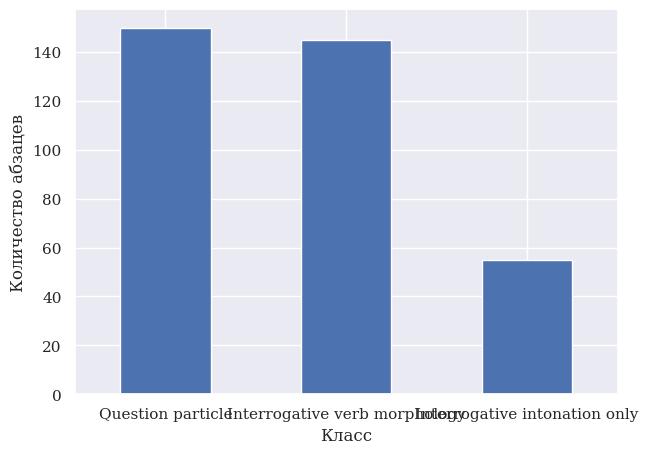

In [6]:
plt.figure()
pd.value_counts(data["target"]).plot.bar()
plt.xlabel("Класс")
plt.ylabel("Количество абзацев")
plt.xticks(rotation=360)
plt.show()

Загружаем токенизатор.

In [7]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", do_lower_case = False)

Выводим на экран токены и их индексы из случайного предложения:

In [8]:
def print_rand_sentence():
    '''Displays the tokens and respective IDs of a random text sample'''
    index = random.randint(0, len(text)-1)
    table = np.array([tokenizer.tokenize(text[index]), 
                      tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
    print(tabulate(table,
                  headers = ["Tokens", "Token IDs"],
                  tablefmt = "fancy_grid"))

print_rand_sentence()

╒══════════════╤═════════════╕
│ Tokens       │   Token IDs │
╞══════════════╪═════════════╡
│ 46           │       11528 │
├──────────────┼─────────────┤
│ .            │         119 │
├──────────────┼─────────────┤
│ to           │       10114 │
├──────────────┼─────────────┤
│ '            │         112 │
├──────────────┼─────────────┤
│ oko          │       14540 │
├──────────────┼─────────────┤
│ ##ad         │       11488 │
├──────────────┼─────────────┤
│ ##ver        │       12563 │
├──────────────┼─────────────┤
│ ##b          │       10457 │
├──────────────┼─────────────┤
│ =            │         134 │
├──────────────┼─────────────┤
│ other        │       10684 │
├──────────────┼─────────────┤
│ thing        │       40414 │
├──────────────┼─────────────┤
│ (            │         113 │
├──────────────┼─────────────┤
│ occurs       │       31136 │
├──────────────┼─────────────┤
│ only         │       10893 │
├──────────────┼─────────────┤
│ with         │       10169 │
├───────

Предобработка текста для BERT:
1. Добавить специальные токены:
- [CLS]: в начало предложения (ID 101)
- [SEP]: в конце предложения (ID 102)
2. Привести предложения к одинаковой длине с помощью паддинга.
- [PAD]: несколько раз в конец предложения (ID 0).
- Максимальная длина предложения – 512 tokens.
3. Создать маску внимания:
- Список 0 и 1, показывающих, должна ли модель рассматривать эти токены.
- [PAD] токены обозначаются 0.

In [9]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
    '''
    Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
      - input_ids: list of token ids
      - token_type_ids: list of token type ids
      - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
    '''
    return tokenizer.encode_plus(
                          input_text,
                          add_special_tokens = True,
                          max_length = 512, 
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_tensors = 'pt',
                          truncation=True
                    )

for sample in text:
    encoding_dict = preprocessing(sample, tokenizer)
    token_id.append(encoding_dict['input_ids']) 
    attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Выводим случайное предложение (уже с масками внимания):

In [10]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ["Tokens", "Token IDs", "Attention Mask"],
                 tablefmt = "fancy_grid"))

print_rand_sentence_encoding()

╒═════════════╤═════════════╤══════════════════╕
│ Tokens      │   Token IDs │   Attention Mask │
╞═════════════╪═════════════╪══════════════════╡
│ [CLS]       │         101 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ 3D          │       17280 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ##L         │       11369 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ -           │         118 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ was         │       10134 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ##h         │       10237 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ -           │         118 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ CA          │       24707 │                1 │
├─────────────┼─────────────┼──────────────────┤
│ ##Y         │       14703 │                1 │
├─────────────┼─────

Разделим выборку и инициализируем датасеты для обучения и валидации:

In [11]:
val_ratio = 0.2

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = False)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Пишем функцию, которая принимает гиперпараметры, обучает модель и выводит метрики:

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [14]:
def bert_experiment(batch_size, lr, epochs):
    # Recommended batch size: 16, 32.
    # Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5.
    # Recommended number of epochs: 2, 3, 4.
    # See: https://arxiv.org/pdf/1810.04805.pdf

    train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size,
        )

    validation_dataloader = DataLoader(
                val_set,
                sampler = SequentialSampler(val_set),
                batch_size = batch_size
            )
    model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr = lr, eps = 1e-08)

    # Run on GPU
    model.cuda()

    for _ in trange(epochs, desc = "Epoch"):

        val_labels = []
        val_preds = []
        
        # ========== Training ==========
        
        # Set model to training mode
        model.train()
        
        # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()
            # Forward pass
            train_output = model(b_input_ids, 
                                token_type_ids = None, 
                                attention_mask = b_input_mask, 
                                labels = b_labels)
            # Backward pass
            train_output.loss.backward()
            optimizer.step()
            # Update tracking variables
            tr_loss += train_output.loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

        # ========== Validation ==========

        # Set model to evaluation mode
        model.eval()

        for batch in validation_dataloader:

            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
              # Forward pass
              eval_output = model(b_input_ids, 
                                  token_type_ids = None, 
                                  attention_mask = b_input_mask)
            label_ids = b_labels.to('cpu').numpy().flatten()
            logits = np.argmax(eval_output.logits.detach().cpu().numpy(), axis = 1).flatten()
            val_preds = np.concatenate([val_preds, logits])
            val_labels = np.concatenate([val_labels, label_ids])
            #print("logits:", logits)
            #print("label_ids", label_ids)

        conf_matrix = confusion_matrix(val_labels, val_preds)

        val_accuracy = accuracy_score(val_labels, val_preds)
        print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
        print('\n\t - Validation accuracy (epoch): {:.4f}'.format(val_accuracy))
        print(classification_report(val_labels, val_preds))

    mismatched_indices = np.where(val_preds != val_labels)
    print(mismatched_indices)
    return mismatched_indices, conf_matrix

Обучаем модель:

In [15]:
mismatched_indices, conf_matrix = bert_experiment(16, 5e-5, 10)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch


	 - Train loss: 1.0384

	 - Validation accuracy (epoch): 0.5571
              precision    recall  f1-score   support

         0.0       0.57      0.95      0.71        40
         1.0       0.33      0.05      0.09        20
         2.0       0.00      0.00      0.00        10

    accuracy                           0.56        70
   macro avg       0.30      0.33      0.27        70
weighted avg       0.42      0.56      0.43        70



Epoch:  20%|██        | 2/10 [00:57<03:49, 28.70s/it]


	 - Train loss: 0.9991

	 - Validation accuracy (epoch): 0.3000
              precision    recall  f1-score   support

         0.0       0.54      0.17      0.26        40
         1.0       0.26      0.70      0.38        20
         2.0       0.00      0.00      0.00        10

    accuracy                           0.30        70
   macro avg       0.27      0.29      0.21        70
weighted avg       0.38      0.30      0.26        70



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  30%|███       | 3/10 [01:25<03:18, 28.41s/it]


	 - Train loss: 0.8220

	 - Validation accuracy (epoch): 0.4429
              precision    recall  f1-score   support

         0.0       0.56      0.47      0.51        40
         1.0       0.33      0.60      0.43        20
         2.0       0.00      0.00      0.00        10

    accuracy                           0.44        70
   macro avg       0.30      0.36      0.31        70
weighted avg       0.41      0.44      0.42        70



Epoch:  40%|████      | 4/10 [01:53<02:49, 28.19s/it]


	 - Train loss: 0.7557

	 - Validation accuracy (epoch): 0.3429
              precision    recall  f1-score   support

         0.0       0.70      0.17      0.28        40
         1.0       0.35      0.85      0.49        20
         2.0       0.00      0.00      0.00        10

    accuracy                           0.34        70
   macro avg       0.35      0.34      0.26        70
weighted avg       0.50      0.34      0.30        70



Epoch:  50%|█████     | 5/10 [02:21<02:20, 28.20s/it]


	 - Train loss: 0.4848

	 - Validation accuracy (epoch): 0.3000
              precision    recall  f1-score   support

         0.0       0.40      0.20      0.27        40
         1.0       0.31      0.55      0.39        20
         2.0       0.14      0.20      0.17        10

    accuracy                           0.30        70
   macro avg       0.28      0.32      0.28        70
weighted avg       0.34      0.30      0.29        70



Epoch:  60%|██████    | 6/10 [02:49<01:52, 28.17s/it]


	 - Train loss: 0.3396

	 - Validation accuracy (epoch): 0.5571
              precision    recall  f1-score   support

         0.0       0.62      0.75      0.68        40
         1.0       0.55      0.30      0.39        20
         2.0       0.27      0.30      0.29        10

    accuracy                           0.56        70
   macro avg       0.48      0.45      0.45        70
weighted avg       0.55      0.56      0.54        70



Epoch:  70%|███████   | 7/10 [03:17<01:24, 28.15s/it]


	 - Train loss: 0.2028

	 - Validation accuracy (epoch): 0.4286
              precision    recall  f1-score   support

         0.0       0.62      0.40      0.48        40
         1.0       0.33      0.70      0.45        20
         2.0       0.00      0.00      0.00        10

    accuracy                           0.43        70
   macro avg       0.32      0.37      0.31        70
weighted avg       0.45      0.43      0.41        70



Epoch:  80%|████████  | 8/10 [03:45<00:56, 28.11s/it]


	 - Train loss: 0.1460

	 - Validation accuracy (epoch): 0.3571
              precision    recall  f1-score   support

         0.0       0.52      0.28      0.36        40
         1.0       0.33      0.65      0.44        20
         2.0       0.10      0.10      0.10        10

    accuracy                           0.36        70
   macro avg       0.32      0.34      0.30        70
weighted avg       0.41      0.36      0.35        70



Epoch:  90%|█████████ | 9/10 [04:13<00:28, 28.09s/it]


	 - Train loss: 0.1266

	 - Validation accuracy (epoch): 0.3571
              precision    recall  f1-score   support

         0.0       0.54      0.35      0.42        40
         1.0       0.31      0.50      0.38        20
         2.0       0.08      0.10      0.09        10

    accuracy                           0.36        70
   macro avg       0.31      0.32      0.30        70
weighted avg       0.41      0.36      0.37        70



Epoch: 100%|██████████| 10/10 [04:41<00:00, 28.19s/it]


	 - Train loss: 0.0738

	 - Validation accuracy (epoch): 0.4000
              precision    recall  f1-score   support

         0.0       0.60      0.38      0.46        40
         1.0       0.32      0.65      0.43        20
         2.0       0.00      0.00      0.00        10

    accuracy                           0.40        70
   macro avg       0.31      0.34      0.30        70
weighted avg       0.43      0.40      0.39        70

(array([ 0,  1,  2,  3,  4,  6,  7,  8, 11, 12, 13, 15, 16, 17, 18, 19, 21,
       22, 23, 27, 28, 29, 31, 35, 36, 37, 38, 45, 46, 47, 48, 49, 50, 52,
       53, 60, 62, 63, 64, 65, 67, 69]),)


In [16]:
val_idx

array([280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292,
       293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331,
       332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344,
       345, 346, 347, 348, 349])

In [17]:
data[280:]['target'].value_counts()

Question particle                40
Interrogative verb morphology    20
Interrogative intonation only    10
Name: target, dtype: int64

[]

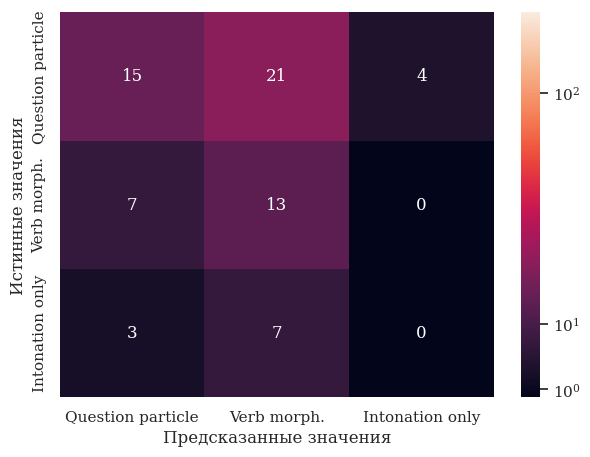

In [19]:
from matplotlib.colors import AsinhNorm
from matplotlib.ticker import MaxNLocator

labels = ['Question particle', 'Verb morph.', 'Intonation only']
ax=plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax, norm=AsinhNorm(clip=True, vmin=0, vmax=200, linear_width=15), cbar_kws={'ticks': [1,10,100]});

# labels, title and ticks
ax.set_xlabel('Предсказанные значения');
ax.set_ylabel('Истинные значения'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);
ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)